In [1]:
from collections import Counter
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import os
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV, LogisticRegressionCV, LassoCV
from sklearn.svm import SVR



import warnings
warnings.filterwarnings('ignore')

The attachment contains:
1. Data dictionary 

2. Training dataset for model building 

3. Testing dataset for submission 

## Problem statement: 

Given is the hourly rental data of an e-scooter rental company. The goal is to predict the total number of e-scooters rented per hour. We recommend using Python for this assignment and are free to use any packages and IDE.  Submissions are evaluated based on how the candidate is able to explore the data using charts, correlation matrix, etc.; and prediction using various modeling methods, the Root Mean Squared Logarithmic Error (RMSLE) as potential evaluation metrics.  

 

## Some guidance: 

Pls submit your analysis/code in Python Notebook, you can show the following results:

1. data pre-processing, feature generation

2. data exploration analysis and visualization

3. modeling - algorithms choices and optimization 

4. final model performance analysis, feature importance 

5. Based on the parameters provided in the testing data, you can use the trained model above (or retrain the model with different set of variables) to predict counts, and add the "count" column in the testing data and submit it.

## Data Description

datetime - hourly date + timestamp 
 
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 
1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [2]:
df = pd.read_csv('training_data.csv').drop(columns=['Unnamed: 0'])
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,2.514929,0.029054,0.684543,1.419040,20.232568,23.651105,61.781350,12.848379,35.962563,155.166973,191.129536
std,1.117485,0.167967,0.464724,0.635637,7.768970,8.458119,19.313038,8.157084,50.103873,150.397856,180.674085
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,16.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,17.498725,49.000000,222.000000,283.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [3]:
df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.023694,-0.006080,0.015364,0.253267,0.260547,0.198741,-0.156544,0.092786,0.160494,0.159331
holiday,0.023694,1.000000,-0.254820,-0.010776,0.002996,-0.002293,0.001392,0.003474,0.049245,-0.022615,-0.005169
workingday,-0.006080,-0.254820,1.000000,0.040086,0.029400,0.024527,-0.003860,0.007291,-0.324122,0.113787,0.004835
weather,0.015364,-0.010776,0.040086,1.000000,-0.052387,-0.052974,0.412188,0.008978,-0.139385,-0.109506,-0.129810
temp,0.253267,0.002996,0.029400,-0.052387,1.000000,0.985248,-0.062023,-0.026653,0.470176,0.323658,0.399809
atemp,0.260547,-0.002293,0.024527,-0.052974,0.985248,1.000000,-0.041475,-0.065143,0.465651,0.318756,0.394473
humidity,0.198741,0.001392,-0.003860,0.412188,-0.062023,-0.041475,1.000000,-0.315437,-0.346864,-0.262550,-0.314745
windspeed,-0.156544,0.003474,0.007291,0.008978,-0.026653,-0.065143,-0.315437,1.000000,0.086100,0.084494,0.094212
casual,0.092786,0.049245,-0.324122,-0.139385,0.470176,0.465651,-0.346864,0.086100,1.000000,0.498520,0.692298
registered,0.160494,-0.022615,0.113787,-0.109506,0.323658,0.318756,-0.262550,0.084494,0.498520,1.000000,0.970674


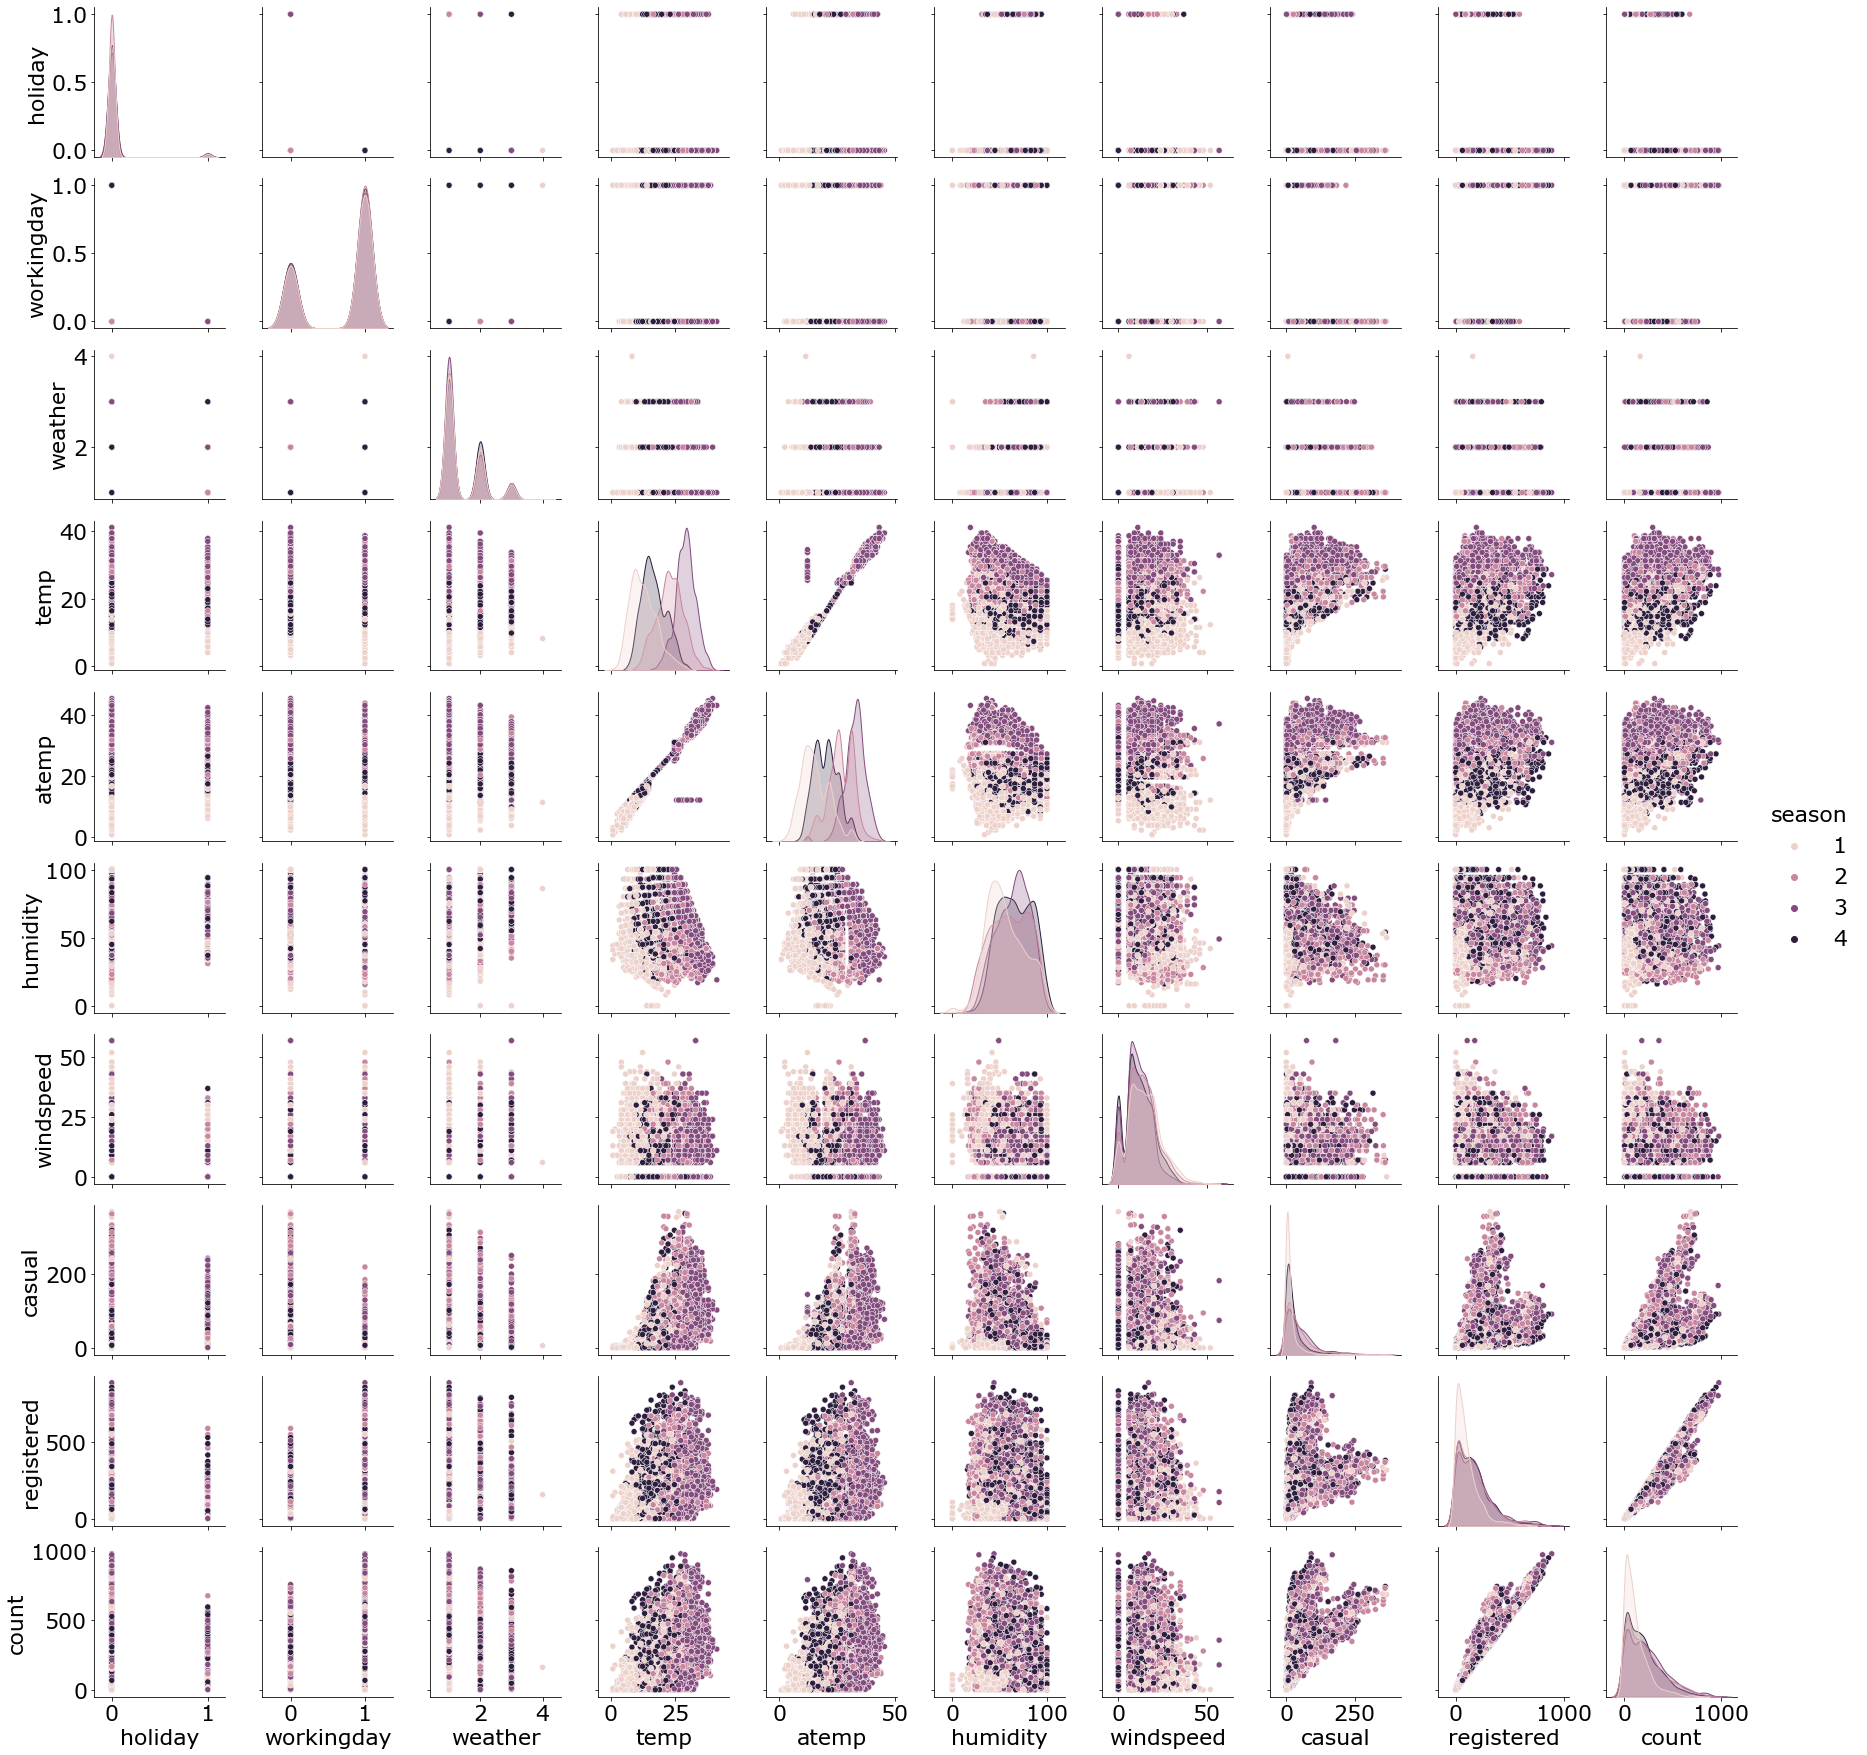

In [4]:
def set_font_size(size=22):

    font = {'family' : 'verdana',
           # 'weight' : 'bold',
            'size'   : size}

    rc('font', **font)
    
set_font_size()

sns.pairplot(df, hue='season')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 [Text(0, 0, '0.76'),
  Text(1, 0, '1.515'),
  Text(2, 0, '2.275'),
  Text(3, 0, '3.03'),
  Text(4, 0, '3.79'),
  Text(5, 0, '4.545'),
  Text(6, 0, '5.305'),
  Text(7, 0, '6.06'),
  Text(8, 0, '6.82'),
  Text(9, 0, '7.575'),
  Text(10, 0, '8.335'),
  Text(11, 0, '9.09'),
  Text(12, 0, '9.85'),
  Text(13, 0, '10.605'),
  Text(14, 0, '11.365'),
  Text(15, 0, '12.12'),
  Text(16, 0, '12.88'),
  Text(17, 0, '13.635'),
  Text(18, 0, '14.395'),
  Text(19, 0, '15.15'),
  Text(20, 0, '15.91'),
  Text(21, 0, '16.665'),
  Text(22, 0, '17.425'),
  Text(23, 0, '18.18'),
  Text(24, 0, '18.94'),
  Text(25, 0, '19.695'),
  Text(26, 0, '20.455'),
  Text(27, 0, '21.21'),
  Text(28, 0, '21.97'),
  Text(29, 0, '22.725'),
  Text(30, 0, 

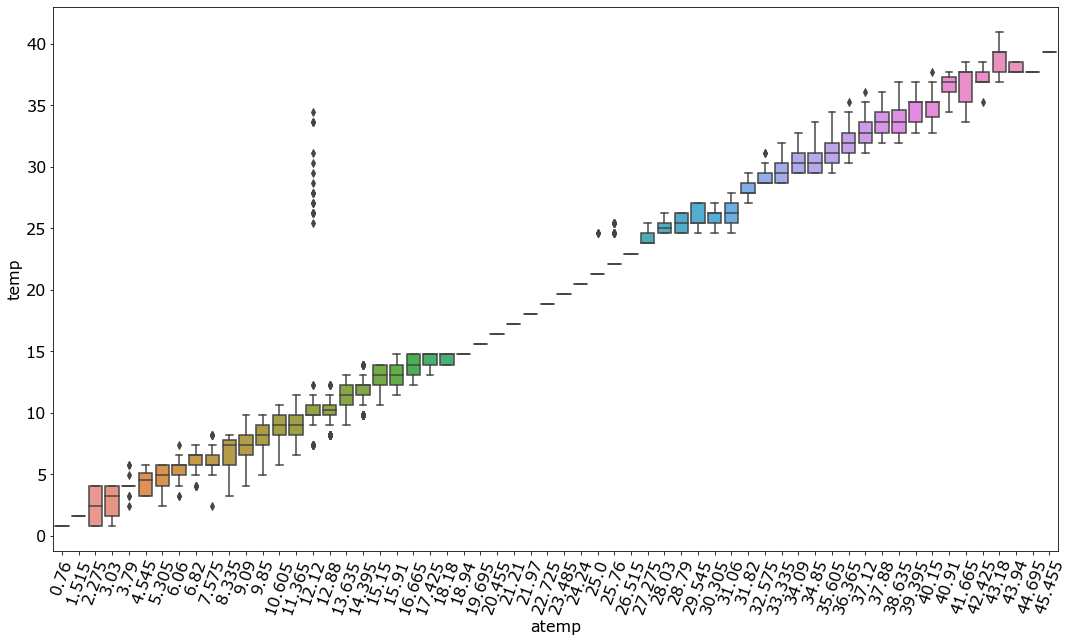

In [5]:
set_font_size(size=16)
fig,ax=plt.subplots(1,1)
fig.set_size_inches(18,10)
sns.boxplot(x='atemp', y='temp', data=df)
plt.xticks(rotation=70)

## dropping atemp

Atemp has corrupted values and is otherwise highly correlted with temp.


In [6]:
df[abs(df.atemp - df.temp) >= 10]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
485,2012-08-17 09:00:00,3,0,1,1,28.70,12.12,58,7.0015,58,320,378
598,2012-08-17 03:00:00,3,0,1,1,26.24,12.12,65,7.0015,0,6,6
605,2012-08-17 12:00:00,3,0,1,1,33.62,12.12,41,15.0013,110,255,365
607,2012-08-17 02:00:00,3,0,1,1,27.06,12.12,61,8.9981,4,15,19
639,2012-08-17 01:00:00,3,0,1,1,27.06,12.12,65,7.0015,16,38,54
1381,2012-08-17 19:00:00,3,0,1,2,30.34,12.12,55,26.0027,88,403,491
2506,2012-08-17 08:00:00,3,0,1,1,27.88,12.12,65,8.9981,43,625,668
3627,2012-08-17 17:00:00,3,0,1,1,33.62,12.12,36,22.0028,144,647,791
3969,2012-08-17 18:00:00,3,0,1,2,33.62,12.12,38,16.9979,108,561,669
4020,2012-08-17 06:00:00,3,0,1,1,25.42,12.12,78,8.9981,6,151,157


<AxesSubplot:>

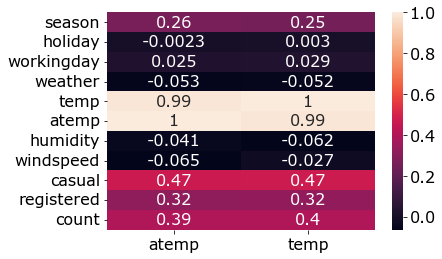

In [7]:
sns.heatmap(df.corr()[['atemp','temp']], annot=True)

<AxesSubplot:>

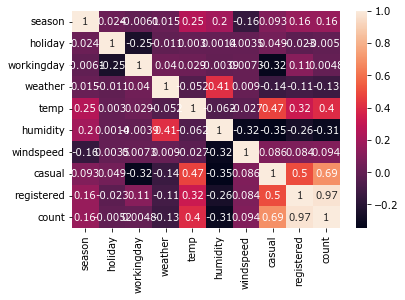

In [8]:
set_font_size(size=10)

dd = df.drop(columns='atemp')

sns.heatmap(dd.corr(), annot=True)

In [9]:
dd = dd.sort_values(by='datetime').reset_index()
new_cols = list(dd.columns[1:])+[dd.columns[0]]
dd = dd[new_cols]
dd

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,index
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0000,3,13,16,7895
1,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0000,0,1,1,6779
2,2011-01-01 06:00:00,1,0,0,1,9.02,80,0.0000,2,0,2,6508
3,2011-01-01 07:00:00,1,0,0,1,8.20,86,0.0000,1,2,3,4087
4,2011-01-01 08:00:00,1,0,0,1,9.84,75,0.0000,1,7,8,4531
...,...,...,...,...,...,...,...,...,...,...,...,...
8703,2012-12-19 18:00:00,4,0,1,1,15.58,50,23.9994,23,546,569,2894
8704,2012-12-19 19:00:00,4,0,1,1,15.58,50,26.0027,7,329,336,2079
8705,2012-12-19 20:00:00,4,0,1,1,14.76,57,15.0013,10,231,241,217
8706,2012-12-19 21:00:00,4,0,1,1,13.94,61,15.0013,4,164,168,4926


## accounting for linear + cyclic relationships

* As time goes on (see below), the number of rentals increases
* The number of rentals is also cyclic in the season 

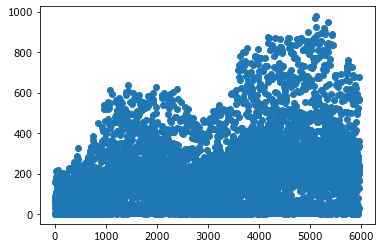

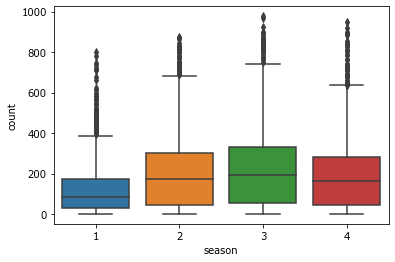

In [21]:

d = dd[dd.workingday==1]

plt.scatter(range(len(d.datetime)), d['count'])
plt.show()

sns.boxplot(y='count',x='season',data=dd[dd.workingday==1])
plt.show()



## encoding month+year, etc

Create three new interesting features combining year, month, hour, season

* hr_season
    - the time of sunup, sundown is probably relevant to the impact of time of day on the counts
    - here we encode "{hour},{season}" as a feature

* yr_month
    - the month alone is not as helpful because of the ever increasing popularity of the scooter
    - it is relevant if it is the first or second May, for example
    - here we encode "{year},{month}" as a feature
    
* yr_season
    - likewise, to separate season from the upward popularity, encode "{year},{season}"
    - could also try "{month},{season}" but dont want to overfit for a first pass

In [22]:
import datetime

def get_dt(dt):
    return datetime.datetime.fromisoformat(dt)

dx = dd.copy()

dx['year'] = [ str((get_dt(x).year - 2011)%2011+1) for x in dx.datetime ]
dx['hour'] = [ str(get_dt(x).time().hour) for x in dx.datetime ]
dx['month'] = [ str(get_dt(x).month) for x in dx.datetime ]
dx['hr_season'] = [ str(get_dt(dx.iloc[idx].datetime).time().hour) + ','+str(dx.iloc[idx].season) for idx in range(len(dx))]
dx['yr_month'] = [ str(get_dt(x).year) + ','+str(get_dt(x).month) for x in dx.datetime ]
dx['yr_season'] = [ str(get_dt(dx.iloc[idx].datetime).year) + ','+str(dd.iloc[idx].season) for idx in range(len(dx)) ]

print(dx[['datetime','year','hour','month','hr_season','yr_month','yr_season']])
print()
print('feature name,','number of disctint values')
print('set of distinct values')
print('='*80)
for time_var in [#'datetime',
                 'season',
                 'year',
                 'hour',
                 'month',
                 'hr_season',
                 'yr_month',
                 'yr_season']:
    print()
    print(time_var,len(list(sorted(list(set(dx[time_var]))))))
    print(list(sorted(list(set(dx[time_var])))))


                 datetime year hour month hr_season yr_month yr_season
0     2011-01-01 00:00:00    1    0     1       0,1   2011,1    2011,1
1     2011-01-01 04:00:00    1    4     1       4,1   2011,1    2011,1
2     2011-01-01 06:00:00    1    6     1       6,1   2011,1    2011,1
3     2011-01-01 07:00:00    1    7     1       7,1   2011,1    2011,1
4     2011-01-01 08:00:00    1    8     1       8,1   2011,1    2011,1
...                   ...  ...  ...   ...       ...      ...       ...
8703  2012-12-19 18:00:00    2   18    12      18,4  2012,12    2012,4
8704  2012-12-19 19:00:00    2   19    12      19,4  2012,12    2012,4
8705  2012-12-19 20:00:00    2   20    12      20,4  2012,12    2012,4
8706  2012-12-19 21:00:00    2   21    12      21,4  2012,12    2012,4
8707  2012-12-19 22:00:00    2   22    12      22,4  2012,12    2012,4

[8708 rows x 7 columns]

feature name, number of disctint values
set of distinct values

season 4
[1, 2, 3, 4]

year 2
['1', '2']

hour 24
['0', '1

### break up into dataframes for continuous/categorical X, y

* Y data:
    - all continuous
    - columns: `['casual', 'registered', 'count']`
    - name: `d_y`
    - name of scaled data: `d_ycont_scaled`
    - scaler: `x_cont_scaler`

* X_data
    - continuous:
        - columns: `['temp', 'humidity', 'windspeed']`
        - name: `d_xcont`
        - name of scaled data: `d_xcont_scaled`
        - scaler: `y_cont_scaler`
 
    - categorical:
    
        - columns: `['holiday', 'workingday', 'weather', 'hr_season', 'yr_month', 'yr_season']`
        - name: `d_xcat`

In [23]:
# all columns:
#          [ #'datetime', 
#           #'season', 
#           'holiday', 
#           'workingday', 
#           'weather', 
#           #'temp',
#           #'humidity', 
#           #'windspeed', 
#           #'casual', 
#           #'registered', 
#           #'count', 
#           'year', 
#           'hr',
#           'month', 
#           'hr_season', 
#           'yr_month', 
#           'yr_season', 
#           'hour']

dx = dx.reset_index(drop=True)

y_vars = [
        'casual', 
        'registered', 
        'count']

x_continuous = [
        'temp',
        'humidity',
        'windspeed']

drop_timevars = [
        'datetime',
        'index',
        'season',
        'year',
        'hour',
        'month']

x_categorical = [ col for col in dx.columns if col not in y_vars+x_continuous+drop_timevars ] 

print('Y:', y_vars)
print('X_cont:', x_continuous)
print('X_cat:', x_categorical)
print('All:', dx.columns)

d_y = dx[y_vars]
d_xcat = dx[x_categorical]
d_xcont = dx[x_continuous]



Y: ['casual', 'registered', 'count']
X_cont: ['temp', 'humidity', 'windspeed']
X_cat: ['holiday', 'workingday', 'weather', 'hr_season', 'yr_month', 'yr_season']
All: Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'index',
       'year', 'hour', 'month', 'hr_season', 'yr_month', 'yr_season'],
      dtype='object')


### examime

In [24]:
d_xcat

,holiday,workingday,weather,hr_season,yr_month,yr_season
0,0,0,1,"0,1","2011,1","2011,1"
1,0,0,1,"4,1","2011,1","2011,1"
2,0,0,1,"6,1","2011,1","2011,1"
3,0,0,1,"7,1","2011,1","2011,1"
4,0,0,1,"8,1","2011,1","2011,1"
...,...,...,...,...,...,...
8703,0,1,1,"18,4","2012,12","2012,4"
8704,0,1,1,"19,4","2012,12","2012,4"
8705,0,1,1,"20,4","2012,12","2012,4"
8706,0,1,1,"21,4","2012,12","2012,4"


## use MinMaxScaler() on the x_continuous, and Y data

### X scaler:

* X continuous data: `d_xcont`
* scaler: `x_cont_scaler`
* transformed data: `d_xcont_scaled`

### Y scaler:
* y data: `d_y`
* scaler: `y_cont_scaler`
* transformed data: `d_ycont_scaled`

### Apply MinMaxScaler to continuous X

In [25]:
x_cont_scaler = MinMaxScaler()
x_cont_scaled = x_cont_scaler.fit_transform(d_xcont.to_numpy())
d_xcont_scaled = pd.DataFrame(columns=d_xcont.columns,
                              data=x_cont_scaled)

d_xcont_scaled

,temp,humidity,windspeed
0,0.224490,0.81,0.000000
1,0.224490,0.75,0.000000
2,0.204082,0.80,0.000000
3,0.183673,0.86,0.000000
4,0.224490,0.75,0.000000
...,...,...,...
8703,0.367347,0.50,0.421065
8704,0.367347,0.50,0.456213
8705,0.346939,0.57,0.263195
8706,0.326531,0.61,0.263195


### checking the inverse transform

In [26]:
pd.DataFrame(columns=d_xcont_scaled.columns,
             data=x_cont_scaler.inverse_transform(d_xcont_scaled.to_numpy()))

,temp,humidity,windspeed
0,9.84,81.0,0.0000
1,9.84,75.0,0.0000
2,9.02,80.0,0.0000
3,8.20,86.0,0.0000
4,9.84,75.0,0.0000
...,...,...,...
8703,15.58,50.0,23.9994
8704,15.58,50.0,26.0027
8705,14.76,57.0,15.0013
8706,13.94,61.0,15.0013


In [27]:
d_xcont

,temp,humidity,windspeed
0,9.84,81,0.0000
1,9.84,75,0.0000
2,9.02,80,0.0000
3,8.20,86,0.0000
4,9.84,75,0.0000
...,...,...,...
8703,15.58,50,23.9994
8704,15.58,50,26.0027
8705,14.76,57,15.0013
8706,13.94,61,15.0013


### apply MinMaxScaler to Y

In [28]:
d_y

,casual,registered,count
0,3,13,16
1,0,1,1
2,2,0,2
3,1,2,3
4,1,7,8
...,...,...,...
8703,23,546,569
8704,7,329,336
8705,10,231,241
8706,4,164,168


In [29]:
y_cont_scaler = MinMaxScaler()
y_cont_scaled = x_cont_scaler.fit_transform(d_y.to_numpy())
d_ycont_scaled = pd.DataFrame(columns=d_y.columns,
                              data=y_cont_scaled)

d_ycont_scaled

,casual,registered,count
0,0.008174,0.014673,0.015369
1,0.000000,0.001129,0.000000
2,0.005450,0.000000,0.001025
3,0.002725,0.002257,0.002049
4,0.002725,0.007901,0.007172
...,...,...,...
8703,0.062670,0.616253,0.581967
8704,0.019074,0.371332,0.343238
8705,0.027248,0.260722,0.245902
8706,0.010899,0.185102,0.171107


In [30]:


def get_dict_vectorized(data, sparse=False, filter_data=False):
    if filter_data:
        data = data[filter_data]
    return DictVectorizer(sparse=sparse).fit_transform(data.to_dict('records'))

# cats = [ #'datetime', 
#           #'season', 
#           'holiday', 
#           'workingday', 
#           'weather', 
#           #'temp',
#           #'humidity', 
#           #'windspeed', 
#           #'casual', 
#           #'registered', 
#           #'count', 
#           'year', 
#           'hr',
#           'month', 
#           'hr_season', 
#           'yr_month', 
#           'yr_season', 
#           'hour']


def get_dummies(data, drop_first=False, filter_data=False):
    if filter_data:
        data = data[filter_data]
    return pd.get_dummies(data, drop_first=drop_first)



In [31]:
get_dict_vectorized(d_xcat)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [32]:
get_dict_vectorized(d_xcat).shape==get_dummies(d_xcat).shape

True

In [33]:
d_xcat

,holiday,workingday,weather,hr_season,yr_month,yr_season
0,0,0,1,"0,1","2011,1","2011,1"
1,0,0,1,"4,1","2011,1","2011,1"
2,0,0,1,"6,1","2011,1","2011,1"
3,0,0,1,"7,1","2011,1","2011,1"
4,0,0,1,"8,1","2011,1","2011,1"
...,...,...,...,...,...,...
8703,0,1,1,"18,4","2012,12","2012,4"
8704,0,1,1,"19,4","2012,12","2012,4"
8705,0,1,1,"20,4","2012,12","2012,4"
8706,0,1,1,"21,4","2012,12","2012,4"


In [34]:
dd.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'index'],
      dtype='object')

In [35]:


v = DictVectorizer(sparse=False)

categories = ['datetime', 
              'season', 
              'holiday', 
              'workingday', 
              'weather', 
              'temp',
              'humidity', 
              'windspeed', 
              'casual', 
              'registered', 
              'count']

D = dd[['holiday','workingday','weather']].to_dict('records')

v.fit_transform(D).shape

(8708, 3)